In [1]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data39602


In [2]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [3]:
# 如果需要进行持久化安装, 需要使用持久化路径, 如下方代码示例:
# If a persistence installation is required, 
# you need to use the persistence path as the following: 
!mkdir /home/aistudio/external-libraries
!pip install beautifulsoup4 -t /home/aistudio/external-libraries

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 13.8 MB/s eta 0:00:00


In [4]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

# 数据处理

In [5]:
!unzip /home/aistudio/data/data39602/images.zip

Archive:  /home/aistudio/data/data39602/images.zip
   creating: images/
   creating: images/face/
   creating: images/face/dilireba/
  inflating: images/face/dilireba/15911604352.jpg  
  inflating: images/face/dilireba/15911604353.jpg  
  inflating: images/face/dilireba/15911604354.jpg  
  inflating: images/face/dilireba/15911604355.jpg  
  inflating: images/face/dilireba/159116043610.jpg  
  inflating: images/face/dilireba/159116043611.jpg  
  inflating: images/face/dilireba/159116043612.jpg  
  inflating: images/face/dilireba/159116043613.jpg  
  inflating: images/face/dilireba/159116043614.jpg  
  inflating: images/face/dilireba/159116043615.jpg  
  inflating: images/face/dilireba/159116043616.jpg  
  inflating: images/face/dilireba/159116043618.jpg  
  inflating: images/face/dilireba/159116043620.jpg  
  inflating: images/face/dilireba/159116043622.jpg  
  inflating: images/face/dilireba/159116043623.jpg  
  inflating: images/face/dilireba/159116043624.jpg  
  inflating: images/fac

## 将图片的类别以及图片的路径存储到一个txt文档中

In [1]:
import os
import json


def datagenerator(datasets_path):
    total_save = {}
    # all classes
    classes_name = os.listdir(datasets_path)
    # classes names
    classes_name = sorted(classes_name)
    print("classes name：", classes_name)

    list_file = open('cls_train.txt', 'w')
    for cls_id, type_name in enumerate(classes_name):
        total_save[cls_id] = type_name
        photos_path = os.path.join(datasets_path, type_name)
        if not os.path.isdir(photos_path):
            continue
        # all images
        photos_name = os.listdir(photos_path)

        for photo_name in photos_name:
            # image id + image path
            list_file.write(
                str(cls_id) + ";" + '%s' % (os.path.join(datasets_path, type_name, photo_name)))
            list_file.write('\n')
    list_file.close()
    # save json
    dict_json = json.dumps(total_save)
    with open('classes.json', 'w+') as file:
        file.write(dict_json)


In [15]:
datasets_path = "./images/face/"
datagenerator(datasets_path=datasets_path)

classes name： ['dilireba', 'jiangwen', 'pengyuyan', 'zhangyan', 'zhangziyi', 'zhaoliying']


## 进行自定义数据集，构建一个三元组的数据集

In [21]:
import numpy as np
from PIL import Image


def cvtColor(image):
    if len(np.shape(image)) == 3 and np.shape(image)[2] == 3:
        return image 
    else:
        image = image.convert('RGB')
        return image 


def resize_image(image, size, letterbox_image):
    iw, ih = image.size
    w, h = size
    if letterbox_image:
        scale = min(w/iw, h/ih)
        nw = int(iw*scale)
        nh = int(ih*scale)

        image = image.resize((nw,nh), Image.BICUBIC)
        new_image = Image.new('RGB', size, (128,128,128))
        new_image.paste(image, ((w-nw)//2, (h-nh)//2))
    else:
        new_image = image.resize((w, h), Image.BICUBIC)
    return new_image


def preprocess_input(image):
    # 255 ---> 1
    image /= 255.0 
    return image


In [3]:
import random

import numpy as np
from PIL import Image
from paddle.io import Dataset


class SearchDataset(Dataset):
    def __init__(self, input_shape, lines, num_classes, random):
        self.input_shape = input_shape
        self.lines = lines
        self.length = len(lines)
        self.num_classes = num_classes
        self.random = random
        # path and label
        self.paths = []
        self.labels = []
        # load data
        self.load_dataset()
        
    def __len__(self):
        return self.length

    def __getitem__(self, index):
        images = np.zeros((3, 3, self.input_shape[0], self.input_shape[1]))
        labels = np.zeros((3))

        # 获取一个类别
        c = random.randint(0, self.num_classes - 1)
        selected_path = self.paths[self.labels[:] == c]
        while len(selected_path) < 2:
            c = random.randint(0, self.num_classes - 1)
            selected_path = self.paths[self.labels[:] == c]

        #   随机选择两张
        image_indexes = np.random.choice(range(0, len(selected_path)), 2)
        #   处理第一张图片
        #   打开图片并放入矩阵
        image = cvtColor(Image.open(selected_path[image_indexes[0]]))
        #   翻转图像
        if self.rand() < 0.5 and self.random:
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        image = resize_image(image, [self.input_shape[1], self.input_shape[0]], letterbox_image = True)
        # 图像预处理
        image = preprocess_input(np.array(image, dtype='float32'))
        image = np.transpose(image, [2, 0, 1])
        # 存储图像以及标签label
        images[0, :, :, :] = image
        labels[0] = c

        # 处理第二张图片
        image = cvtColor(Image.open(selected_path[image_indexes[1]]))
        #   翻转图像
        if self.rand()<.5 and self.random: 
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        image = resize_image(image, [self.input_shape[1], self.input_shape[0]], letterbox_image = True)
        image = preprocess_input(np.array(image, dtype='float32'))
        image = np.transpose(image, [2, 0, 1])
        images[1, :, :, :] = image
        labels[1] = c

        #   取出第三个人的人脸
        different_c = list(range(self.num_classes))
        different_c.pop(c)
        different_c_index = np.random.choice(range(0, self.num_classes - 1), 1)
        current_c = different_c[different_c_index[0]]
        selected_path = self.paths[self.labels == current_c]
        while len(selected_path)<1:
            different_c_index   = np.random.choice(range(0, self.num_classes - 1), 1)
            current_c           = different_c[different_c_index[0]]
            selected_path       = self.paths[self.labels == current_c]

        #   随机选择一张
        image_indexes = np.random.choice(range(0, len(selected_path)), 1)
        image = cvtColor(Image.open(selected_path[image_indexes[0]]))
        #   翻转图像
        if self.rand()<.5 and self.random: 
            image = image.transpose(Image.FLIP_LEFT_RIGHT)
        image = resize_image(image, [self.input_shape[1], self.input_shape[0]], letterbox_image = True)
        image = preprocess_input(np.array(image, dtype='float32'))
        image = np.transpose(image, [2, 0, 1])
        images[2, :, :, :] = image
        labels[2] = current_c

        # images:三个人脸的数据，labels：三个人脸对应的类别
        return images, labels

    def rand(self, a=0, b=1):
        return np.random.rand()*(b-a) + a
    
    def load_dataset(self):
        for path in self.lines:
            path_split = path.split(";")
            # paths
            self.paths.append(path_split[1].split()[0])
            # labels
            self.labels.append(int(path_split[0]))
        self.paths = np.array(self.paths,dtype=np.object)
        self.labels = np.array(self.labels)


    # DataLoader collate_fn
    def dataset_collate(self, batch):
        # batch:输入一个batch的数据
        images = []
        labels = []
        for img, label in batch:
            images.append(img)
            labels.append(label)
        # caocat image data
        images1 = np.array(images)[:, 0, :, :, :]
        images2 = np.array(images)[:, 1, :, :, :]
        images3 = np.array(images)[:, 2, :, :, :]
        images = np.concatenate([images1, images2, images3], 0)
        # concat label data
        labels1 = np.array(labels)[:, 0]
        labels2 = np.array(labels)[:, 1]
        labels3 = np.array(labels)[:, 2]
        labels = np.concatenate([labels1, labels2, labels3], 0)
        return images, labels



## 构建数据集并创建dataloader

In [4]:
import os
import paddle
import paddle.nn as nn
from paddle.nn import functional as F
from tqdm import tqdm
import argparse
import paddle.optimizer as optim
from paddle.io import DataLoader

In [5]:
input_shape = [224, 224, 3]
num_classes = 6
annotation_path = "./cls_train.txt"
# batchsize需要为3的倍数
batch_size = 15
with open(annotation_path, "r") as f:
    lines = f.readlines()
num_train = len(lines)

# build dataset
train_dataset = SearchDataset(input_shape, lines, num_classes, random=True)
# build dataloader
train_loader = DataLoader(train_dataset,
                    shuffle=True,
                    batch_size=batch_size // 3,
                    num_workers=4,
                    drop_last=True,
                    collate_fn=train_dataset.dataset_collate)

In [6]:
print("number of train:", len(train_dataset))

number of train: 708


# 构建网络结构，此处先采用动态图结构

In [7]:
import paddle.nn as nn
import paddle
from paddle.nn import functional as F
import paddle.vision.models as models

In [8]:
class OwnResnet(nn.Layer):
    def __init__(self, pretrained):
        super(OwnResnet, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        # 删除不需要的层结构
        del self.model.fc
        del self.model.avgpool

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        return x


class OwnFacenet(nn.Layer):
    def __init__(self, dropout_keep_prob=0.5, embedding_size=128, num_classes=None, mode="train", pretrained=False):
        super(OwnFacenet, self).__init__()
        self.backbone = OwnResnet(pretrained=pretrained)
        flat_shape = 2048
        self.set_parameter_requires_grad(self.backbone, True)
        self.avg = nn.AdaptiveAvgPool2D((1, 1))
        self.flatten = paddle.nn.Flatten()
        self.Dropout = nn.Dropout(1 - dropout_keep_prob)
        self.Bottleneck = nn.Linear(flat_shape, embedding_size)
        self.last_bn = nn.BatchNorm1D(embedding_size)
        if mode == "train":
            self.classifier = nn.Linear(embedding_size, num_classes)

    def set_parameter_requires_grad(self, model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = True

    def forward(self, x):
        if self.training:
            x = self.backbone(x)
            x = self.avg(x)
            x = self.flatten(x)
            x = self.Dropout(x)
            x = self.Bottleneck(x)
            x = self.last_bn(x)
            # 分类的结果
            x1 = self.classifier(x)
            # L2标准化之后的结果
            x2 = F.normalize(x, p=2, axis=1)
            return x1, x2
        else:
            x = self.backbone(x)
            x = self.avg(x)
            x = self.flatten(x)
            x = self.Dropout(x)
            x = self.Bottleneck(x)
            x = self.last_bn(x)
            # l2标准化后的结果
            x = F.normalize(x, p=2, axis=1)
            return x

In [9]:
# build model
pretrained = True
model = OwnFacenet(num_classes=num_classes, pretrained=pretrained)

W0503 22:28:13.667455   210 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0503 22:28:13.670624   210 device_context.cc:465] device: 0, cuDNN Version: 8.2.
100%|██████████| 151272/151272 [00:04<00:00, 35334.16it/s]


# 构建损失函数，采用三元损失函数

In [8]:
def triplet_loss(alpha = 0.2):
    def _triplet_loss(y_pred, Batch_size):
        # 获取到对应的三元特征
        anchor, positive, negative = y_pred[:int(Batch_size)], y_pred[int(Batch_size):int(2*Batch_size)], y_pred[int(2*Batch_size):]

        pos_dist = paddle.sqrt(paddle.sum(paddle.pow(anchor - positive,2), axis=-1))
        neg_dist = paddle.sqrt(paddle.sum(paddle.pow(anchor - negative,2), axis=-1))

        basic_loss = paddle.where(pos_dist - neg_dist + alpha > 0, pos_dist - neg_dist + alpha, paddle.to_tensor(0.0))

        loss = paddle.mean(basic_loss)
        # # 产生损失
        # keep_all = (neg_dist - pos_dist < alpha).cpu().numpy().flatten()
        # hard_triplets = np.where(keep_all == 1)

        # print(hard_triplets)

        # pos_dist = pos_dist[hard_triplets]
        # neg_dist = neg_dist[hard_triplets]

        # basic_loss = pos_dist - neg_dist + alpha
        # # 取均值损失
        # loss = paddle.sum(basic_loss) / paddle.max(paddle.assign([1, len(hard_triplets[0])]))
        return loss
    return _triplet_loss

In [9]:
# build loss
loss = triplet_loss()

# 构建优化器

In [10]:
# build optim
optimizer_type = 'adam'
optimizer = {
    'adam': optim.Adam(parameters = model.parameters(), learning_rate = 0.001),
    'sgd': optim.SGD(parameters = model.parameters(), learning_rate = 0.01)
}[optimizer_type]

NameError: name 'model' is not defined

# 开始训练

In [11]:
def fit_one_epoch(model, loss, optimizer, epoch, epoch_step, gen, Epoch, Batch_size, save_period, save_dir):
    # triple loss
    total_triple_loss = 0
    # cross entroy
    total_CE_loss = 0
    # total acc
    total_accuracy = 0

    model.train()
    with tqdm(total=epoch_step, desc=f'Epoch {epoch + 1}/{Epoch}', postfix=dict, mininterval=0.3) as pbar:
        for iteration, batch in enumerate(gen):
            if iteration >= epoch_step:
                break
            images, labels = batch
            with paddle.no_grad():
                images = paddle.to_tensor(images.astype('float32'))
                labels = paddle.to_tensor(labels.astype('int64'))

            optimizer.clear_grad()
            # 得到分类的数据以及L2标准化之前的数据
            outputs2, outputs1 = model(images)
            # 三元损失函数
            _triplet_loss = loss(outputs1, Batch_size)
            # 交叉熵损失函数
            _CE_loss = nn.NLLLoss()(F.log_softmax(outputs2), labels)
            # 损失相加
            _loss = _triplet_loss + _CE_loss

            _loss.backward()
            optimizer.step()

            with paddle.no_grad():
                accuracy = paddle.mean(
                    (paddle.argmax(F.softmax(outputs2), axis=-1) == labels))

            total_triple_loss += _triplet_loss.item()
            total_CE_loss += _CE_loss.item()
            total_accuracy += accuracy.item()

            pbar.set_postfix(**{'total_triple_loss': total_triple_loss / (iteration + 1),
                                'total_CE_loss': total_CE_loss / (iteration + 1),
                                'accuracy': total_accuracy / (iteration + 1)})
            pbar.update(1)
    print('Epoch:' + str(epoch + 1) + '/' + str(Epoch))
    print('Total Loss: %.4f' % ((total_triple_loss + total_CE_loss) / epoch_step))
    if (epoch + 1) % save_period == 0 or epoch + 1 == Epoch:
        paddle.save(model.state_dict(), os.path.join(save_dir, 'ep%02d.pth' % (epoch + 1)))

In [14]:
epoch_step = num_train // batch_size
epochs = 10
save_period = 5
save_dir = "./output/"
# train
for epoch in range(epochs):
    fit_one_epoch(model, loss, optimizer,
                    epoch, epoch_step, train_loader,
                    epochs, batch_size // 3, save_period, save_dir)

Epoch 1/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:653: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")
Epoch 2/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:1/10
Total Loss: 1.0842


Epoch 3/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:2/10
Total Loss: 0.7044


Epoch 4/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:3/10
Total Loss: 0.5315


Epoch 5/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:4/10
Total Loss: 0.2998


Epoch 5/10: 100%|██████████| 47/47 [00:04<00:00,  9.83it/s, accuracy=1, total_CE_loss=0.363, total_triple_loss=0.0143] 


Epoch:5/10
Total Loss: 0.3772


Epoch 7/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:6/10
Total Loss: 0.3878


Epoch 8/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:7/10
Total Loss: 0.3072


Epoch 9/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:8/10
Total Loss: 0.2779


Epoch 10/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:9/10
Total Loss: 0.2044


Epoch 10/10: 100%|██████████| 47/47 [00:04<00:00, 10.58it/s, accuracy=1, total_CE_loss=0.243, total_triple_loss=0.0139]


Epoch:10/10
Total Loss: 0.2573


# 预测过程，将图像库中的人脸转换为高维度特征中

In [17]:
import json
model.eval()
total_embedding = {}
with open("./cls_train.txt", "r") as f:
    lines = f.readlines()

for line in tqdm(lines):
    path = line.split(";")[1].split()[0]
    image_data = Image.open(path)
    with paddle.no_grad():
        image_data = resize_image(image_data, [input_shape[1], input_shape[0]], letterbox_image=True)

        photo_data = paddle.to_tensor(
            np.expand_dims(np.transpose(preprocess_input(np.array(image_data, np.float32)), (2, 0, 1)), 0))

        output = model(photo_data).cpu().numpy().tolist()

        total_embedding[path] = output

# 转化为json格式文件
dict_json = json.dumps(total_embedding)
# save
with open('image_feature.json', 'w+') as file:
    file.write(dict_json)

100%|██████████| 708/708 [00:22<00:00, 31.47it/s]


## 输入一张测试图片进行测试

In [23]:
image_test_path = input('Input image filename:')
image_test = Image.open(image_test_path)
with paddle.no_grad():
    image_test = resize_image(image_test, [input_shape[1], input_shape[0]], letterbox_image=True)

    photo_test = paddle.to_tensor(
        np.expand_dims(np.transpose(preprocess_input(np.array(image_test, np.float32)), (2, 0, 1)), 0))

    photo_test = photo_test.cuda()
    output_test = model(photo_test).cpu().numpy()

total_diff = {}
for key,value in total_embedding.items():
    value = np.array(value)
    total_diff[key] = np.linalg.norm(output_test - value, axis=1)

print(total_diff)


Input image filename: ./test.png


{'./images/face/dilireba/1591160437114.jpg': array([1.52943838]), './images/face/dilireba/159116043766.jpg': array([1.81909941]), './images/face/dilireba/159116043761.jpg': array([1.72572565]), './images/face/dilireba/159116043652.jpg': array([1.62632892]), './images/face/dilireba/159116043631.jpg': array([1.49347721]), './images/face/dilireba/159116043787.jpg': array([1.54048517]), './images/face/dilireba/159116043638.jpg': array([1.72115597]), './images/face/dilireba/159116043618.jpg': array([1.67191251]), './images/face/dilireba/159116043791.jpg': array([1.57484631]), './images/face/dilireba/159116043629.jpg': array([1.56656123]), './images/face/dilireba/15911604352.jpg': array([1.59859238]), './images/face/dilireba/1591160438117.jpg': array([1.67207121]), './images/face/dilireba/159116043783.jpg': array([1.68600151]), './images/face/dilireba/159116043765.jpg': array([1.67974763]), './images/face/dilireba/1591160437103.jpg': array([1.6821898]), './images/face/dilireba/159116043634.j

## 将与之最像的三张图展示出来

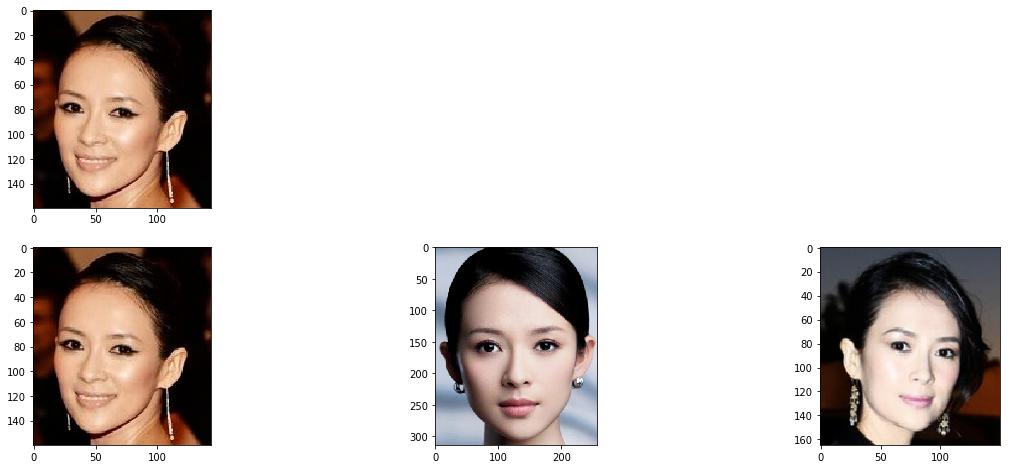

In [26]:
import matplotlib.pyplot as plt

sorted_total_diff = sorted(total_diff.items(),key=lambda x:x[1])
use_data = sorted_total_diff[:3]

fig = plt.figure(figsize=(20, 8))
# src image
src_data_path = image_test_path
img = Image.open(src_data_path)
ax = fig.add_subplot(2, 3, 1)
ax.imshow(img)
for i in range(len(use_data)):
    sub_data = use_data[i]
    sub_data_path = sub_data[0]
    img = Image.open(sub_data_path)
    ax = fig.add_subplot(2, 3, i + 4)
    ax.imshow(img)

plt.show()

In [27]:
use_data

[('./images/face/zhangziyi/20181206112348.png', array([0.])),
 ('./images/face/zhangziyi/20181206132239.png', array([0.10651628])),
 ('./images/face/zhangziyi/20181206131856.png', array([0.12617998]))]

## 输出类别名称

In [28]:
import os
classes_dict = {}
for i in range(5):
    sub_key = os.path.split(os.path.split(sorted_total_diff[i][0])[0])[1]
    count = classes_dict.get(sub_key, 0)
    count += 1
    classes_dict[sub_key] = count

print(classes_dict)
sorted_classes_dict = sorted(classes_dict.items(),key=lambda x:x[1])
print("this is", sorted_classes_dict[-1][0])

{'zhangziyi': 5}
this is zhangziyi


# 使用 paddle.jit.to_static 实现动转静

## 改写网络

In [16]:
class OwnResnet2(nn.Layer):
    def __init__(self, pretrained):
        super(OwnResnet2, self).__init__()
        self.model = models.resnet50(pretrained=pretrained)
        # 删除不需要的层结构
        del self.model.fc
        del self.model.avgpool

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        return x


class OwnFacenet2(nn.Layer):
    def __init__(self, dropout_keep_prob=0.5, embedding_size=128, num_classes=None, pretrained=False):
        super(OwnFacenet2, self).__init__()
        self.backbone = OwnResnet2(pretrained=pretrained)
        flat_shape = 2048
        self.set_parameter_requires_grad(self.backbone, True)
        self.avg = nn.AdaptiveAvgPool2D((1, 1))
        self.flatten = paddle.nn.Flatten()
        self.Dropout = nn.Dropout(1 - dropout_keep_prob)
        self.Bottleneck = nn.Linear(flat_shape, embedding_size)
        self.last_bn = nn.BatchNorm1D(embedding_size)
        # if mode == "train":
        self.classifier = nn.Linear(embedding_size, num_classes)

    def set_parameter_requires_grad(self, model, feature_extracting):
        if feature_extracting:
            for param in model.parameters():
                param.requires_grad = True

    @paddle.jit.to_static()
    def forward(self, x):
        if self.training:
            x = self.backbone(x)
            x = self.avg(x)
            x = self.flatten(x)
            x = self.Dropout(x)
            x = self.Bottleneck(x)
            x = self.last_bn(x)
            # 分类的结果
            x1 = self.classifier(x)
            # L2标准化之后的结果
            x2 = F.normalize(x, p=2, axis=1)
            return x1, x2
        else:
            x = self.backbone(x)
            x = self.avg(x)
            x = self.flatten(x)
            x = self.Dropout(x)
            x = self.Bottleneck(x)
            x = self.last_bn(x)
            # l2标准化后的结果
            x = F.normalize(x, p=2, axis=1)
            return x

In [17]:
# build model
pretrained = True
model_2 = OwnFacenet2(num_classes=num_classes, pretrained=pretrained)

W0503 22:52:05.170619   170 device_context.cc:447] Please NOTE: device: 0, GPU Compute Capability: 8.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0503 22:52:05.173643   170 device_context.cc:465] device: 0, cuDNN Version: 8.2.
100%|██████████| 151272/151272 [00:05<00:00, 28325.70it/s]


In [18]:
# build optim
optimizer_type = 'adam'
optimizer = {
    'adam': optim.Adam(parameters = model_2.parameters(), learning_rate = 0.001),
    'sgd': optim.SGD(parameters = model_2.parameters(), learning_rate = 0.01)
}[optimizer_type]

In [19]:
model_info = paddle.summary(model_2, (10, 3, 224, 224))
print(model_info)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-1       [[10, 3, 224, 224]]   [10, 64, 112, 112]       9,408     
   BatchNorm2D-1    [[10, 64, 112, 112]]  [10, 64, 112, 112]        256      
      ReLU-1        [[10, 64, 112, 112]]  [10, 64, 112, 112]         0       
    MaxPool2D-1     [[10, 64, 112, 112]]   [10, 64, 56, 56]          0       
     Conv2D-3        [[10, 64, 56, 56]]    [10, 64, 56, 56]        4,096     
   BatchNorm2D-3     [[10, 64, 56, 56]]    [10, 64, 56, 56]         256      
      ReLU-2        [[10, 256, 56, 56]]   [10, 256, 56, 56]          0       
     Conv2D-4        [[10, 64, 56, 56]]    [10, 64, 56, 56]       36,864     
   BatchNorm2D-4     [[10, 64, 56, 56]]    [10, 64, 56, 56]         256      
     Conv2D-5        [[10, 64, 56, 56]]   [10, 256, 56, 56]       16,384     
   BatchNorm2D-5    [[10, 256, 56, 56]]   [10, 256, 56, 56]   

## 模型训练

In [23]:
epoch_step = num_train // batch_size
epochs = 10
save_period = 5
save_dir = "./output2/"
# train
for epoch in range(epochs):
    fit_one_epoch(model_2, loss, optimizer,
                    epoch, epoch_step, train_loader,
                    epochs, batch_size // 3, save_period, save_dir)

Epoch 2/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:1/10
Total Loss: 1.0193


Epoch 3/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:2/10
Total Loss: 0.5124


Epoch 4/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:3/10
Total Loss: 0.4087


Epoch 5/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:4/10
Total Loss: 0.5735


Epoch 5/10: 100%|██████████| 47/47 [00:04<00:00, 11.74it/s, accuracy=1, total_CE_loss=0.289, total_triple_loss=0.0133] 


Epoch:5/10
Total Loss: 0.3026


Epoch 7/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:6/10
Total Loss: 0.3324


Epoch 8/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:7/10
Total Loss: 0.3166


Epoch 9/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:8/10
Total Loss: 0.3548


Epoch 10/10:   0%|          | 0/47 [00:00<?, ?it/s<class 'dict'>]

Epoch:9/10
Total Loss: 0.4138


Epoch 10/10: 100%|██████████| 47/47 [00:04<00:00, 10.92it/s, accuracy=1, total_CE_loss=0.251, total_triple_loss=0.0129]


Epoch:10/10
Total Loss: 0.2637


## 使用 paddle.jit.save 保存动转静模型

In [24]:
paddle.jit.save(model_2, 'model')

Tue May 03 22:55:33 Dynamic-to-Static WARNING: Current function: forward(x), input_spec: None has more than one cached programs: 2, the last traced progam will be return by default.


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 